Join the data from Part 1 with the data from Part 2 to create a new dataframe.

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

foursquare_api_key = os.getenv('Foursquare_api_key')
yelp_api_key = os.getenv('Yelp_api_key')

In [ ]:
# Retrieve bike station data
url = "http://api.citybik.es/v2/networks"
response = requests.get(url)

if response.status_code == 200:
    response_data = response.json()
    print(response_data) # check the format of the response
    networks = response_data.get('networks', [])
    df_networks = pd.DataFrame(networks)
    print(df_networks)
    df_networks.to_csv('C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/df_networks.csv') # to check the format as excel. this provides more clear picture

    # select the vancouver city from the data and filter bike station name, latitude and longitude
    vancouver_network = None
    
    for i in networks:
        if i['location']['city'].lower() == 'vancouver': # select the city as Vancouver
            vancouver_network = i
            break
    
    if vancouver_network:
        network_id = vancouver_network['id'] # get the vancouver city id
        details_url = f"http://api.citybik.es/v2/networks/{network_id}" # point to the vancouver city endpoint by city id
        details_response = requests.get(details_url)
        
        if details_response.status_code == 200:
            vancouver_details = details_response.json()
            print(vancouver_details) 
            df_vancouver_details = pd.DataFrame(vancouver_details)
            print(df_vancouver_details)
            stations = vancouver_details['network']['stations']
            
            vancouver_data = [{'Name': station['name'], 'Latitude': station['latitude'], 'Longitude': station['longitude']} for station in stations]
            df_vancouver_data = pd.DataFrame(vancouver_data)
            df_vancouver_data.to_csv('C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/citybike_created_df.csv') # to check the format as excel. this provides more clear picture
        else:
            raise Exception(f"Failed to retrieve details for Vancouver network: {details_response.status_code}")
    else:
        raise Exception("Vancouver network not found.")
else:
    raise Exception(f"Failed to retrieve data: {response.status_code}")

In [3]:
headers = {
    "Accept": "application/json",
    "Authorization": f"{foursquare_api_key}"
}

url = "https://api.foursquare.com/v3/places/search"
params = {
    'radius': 100000,
    'll': '49.262487,-123.114397',
    'categories': '13065,13056', 
    'fields': 'name,geocodes'
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    response_data = response.json()
    restaurant_bars_places = response_data.get('results', [])
    df_restaurant_bars_places = pd.DataFrame(restaurant_bars_places)

    df_restaurant_bars_places.to_csv('C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/df_restaurant_bars_places.csv')
    dining_and_drinking = [
        {
            'Name': i.get('name'),
            'Latitude': i['geocodes']['main']['latitude'] if 'geocodes' in i and 'main' in i['geocodes'] else None,
            'Longitude': i['geocodes']['main']['longitude'] if 'geocodes' in i and 'main' in i['geocodes'] else None
        }
        for i in restaurant_bars_places
    ]
    
    df_dining_and_drinking = pd.DataFrame(dining_and_drinking)
    df_dining_and_drinking.to_csv('C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/foursquare_created_df.csv')
else:
    raise Exception(f"Error: {response.status_code}, {response.text}")

In [4]:
# check the data type & column names of dataframes
print(f"Data types of table bike station\n{df_vancouver_data.dtypes}")
print(f"Data types of table restarant & bars\n{df_dining_and_drinking.dtypes}")

# it seems both datatypes and columns are compatible

Data types of table bike station
Name          object
Latitude     float64
Longitude    float64
dtype: object
Data types of table restarant & bars
Name          object
Latitude     float64
Longitude    float64
dtype: object


In [5]:
# check the missing values

# Check missing values in df_vancouver_data
missing_vancouver = df_vancouver_data.isnull().sum()
print("Missing values in df_vancouver_data:\n", missing_vancouver)

# Check missing values in df_dining_and_drinking
missing_dining = df_dining_and_drinking.isnull().sum()
print("Missing values in df_dining_and_drinking:\n", missing_dining)

# no missing values

Missing values in df_vancouver_data:
 Name         0
Latitude     0
Longitude    0
dtype: int64
Missing values in df_dining_and_drinking:
 Name         0
Latitude     0
Longitude    0
dtype: int64


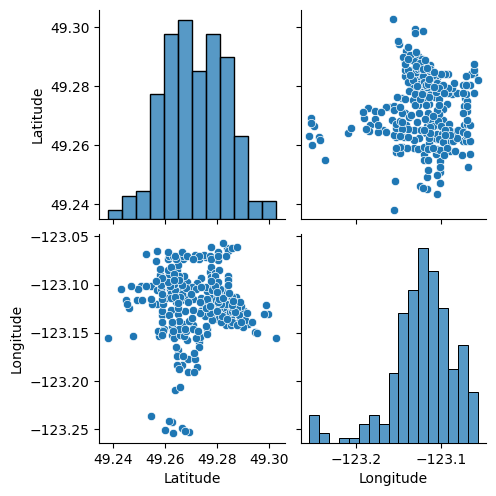

In [6]:
sns.pairplot(df_vancouver_data)

# it seems there is no outliers that we can consider

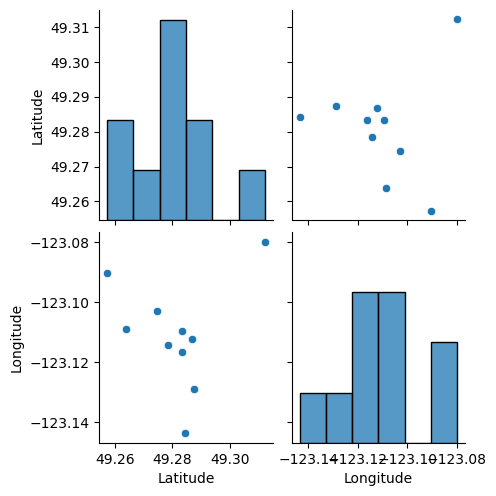

In [7]:
sns.pairplot(df_dining_and_drinking)
# it seems there is no outliers that we can consider

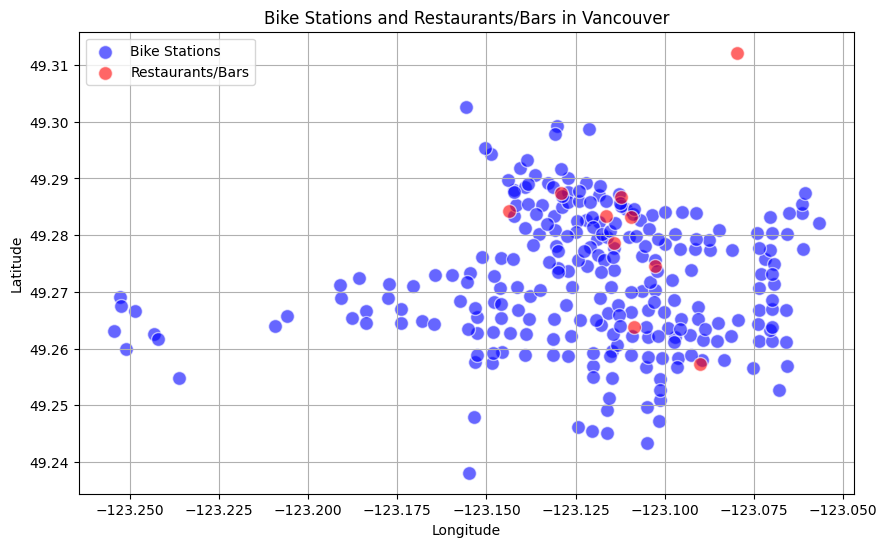

In [8]:
df_vancouver_data['Type'] = 'Bike Station'
df_dining_and_drinking['Type'] = 'Restaurant/Bar'
combined_df = pd.concat([df_vancouver_data, df_dining_and_drinking])

combined_df.to_csv('C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/combined_df.csv')

plt.figure(figsize=(10, 6))
plt.scatter(df_vancouver_data['Longitude'], df_vancouver_data['Latitude'], label='Bike Stations', color='blue', alpha=0.6, edgecolors='w', s=100)
plt.scatter(df_dining_and_drinking['Longitude'], df_dining_and_drinking['Latitude'], label='Restaurants/Bars', color='red', alpha=0.6, edgecolors='w', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bike Stations and Restaurants/Bars in Vancouver')
plt.legend()
plt.grid(True)
plt.show()

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [9]:
import sqlite3

# Define the path to your SQLite database
db_path = 'C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/project_data.db'

# Create a connection to the SQLite database
conn = sqlite3.connect(db_path)

# Write DataFrames to SQLite database
df_vancouver_data.to_sql('bike_stations', conn, if_exists='replace', index=False)
df_dining_and_drinking.to_sql('restaurants_bars', conn, if_exists='replace', index=False)
combined_df.to_sql('combined_data', conn, if_exists='replace', index=False)

# Commit changes and close the connection
conn.commit()
conn.close()

In [10]:
# Get the longitude and latitude of a particular bike station by name
db_path = 'C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/project_data.db'

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# select the bike station name that require the latitude and logitude 
station_name = 'Cambie & Water'

query = """
SELECT Latitude, Longitude 
FROM bike_stations
WHERE Name = ?
"""

# Execute the query
cursor.execute(query, (station_name,)) 
result = cursor.fetchone()

# Check if the result is not None
if result:
    latitude, longitude = result
    print(f"The latitude and longitude of '{station_name}' are: {latitude}, {longitude}")
else:
    print(f"No bike station found with the name '{station_name}'")

# Close the connection
conn.close()

The latitude and longitude of 'Cambie & Water' are: 49.284605, -123.108662


Look at the data before and after the join to validate your data.